# Analyzing HSPCs with the {class}`~moscot.problems.time.TemporalProblem`

In this tutorial, we showcase using gene expression (GEX) and chromatin accessibility (ATAC) to analyze the trajectory of HSPC cells on a time-resolved dataset. The method builds upon {cite}`schiebinger:19`.


:::{seealso}
- See {doc}`500_spatiotemporal` on how to incorporate spatial information as additional prior.
- See {doc}`100_temporal_problem` on how to incorporate lineage information as additional prior. 
:::

## Mapping cells across time points

Given measurements of any modality across time we can reconstruct the trajectories by mapping cells across time. We assume that we have the same measurement at each time point, resulting in a W-type OT problem. 


In its simplest form, we use unbalanced ({cite}`chizat:18`) entropic OT {cite}`cuturi:2013` to account for unbalancedness while speeding up computations and to improve the statistical properties of the solution {cite}`peyre:19`. We use the following definitions: 

- $a$ and $b$: marginal distributions over early and late cells, respectively, representing any prior knowledge, including growth and death rates. 
- $\varepsilon$: weight given to entropic regularitation. Larger values will lead to more "blurred" couplings. 
- $\tau_a$ representing the unbalancedness in the source distribution. $tau_a=1$ corresponds to the fully balanced case, while $\tau_a < 1$ allows unbalancedness, e.g. a cell might have no descendant because it dies or a cell could have multiple descendants as it proliferates. Note that this is not the same as using prior information about the marginals obtained from the expression from proliferation and apoptosis markers. We normally combine both approaches, but if prior estimates are available, $tau_a$ can be chosen closer to 1.
- $\tau_b$: unbalancedness parameter in the target marginals. Analogously defined to $tau_a$.

## Preliminaries

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import warnings
from typing import List, Literal, Optional, Tuple

import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem
from tqdm.std import TqdmWarning

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", TqdmWarning)

### Dataset description

The {func}`~moscot.datasets.hspc` dataset is a subset from the [Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2022](https://openproblems.bio/competitions/neurips_2022/) and includes, among other:

- {attr}`obs['time'] <anndata.AnnData.obs>`, representing time point information for cells at days `2`, `3`, `4`, and `7`.
- {attr}`obsm['X_pca'] <anndata.AnnData.obsm>`, containing the PCA of processed gene expression. 
- {attr}`obsm['X_lsi'] <anndata.AnnData.obsm>`, containing the [LSI](https://en.wikipedia.org/wiki/Latent_semantic_analysis) of the processed [tf-idf](https://en.wikipedia.org/wiki/Tf–idf)-transformed ATAC data, see e.g. [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) on how to preprocess ATAC data. 

Cell type annotation is very coarse in this dataset and was done based *only* on gene expression resulting in the following annotations:

- MasP = Mast Cell Progenitors
- MkP = Megakaryocyte Progenitors
- NeuP = Neutrophil Progenitors
- MoP = Monocyte Progenitors
- EryP = Erythrocyte Progenitors
- HSC = Hematopoietic Stem Cells
- BP = B-Cell Progenitors

In [141]:
adata = mt.datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

## Visualise the data

First, we consider the cell type annotations in a UMAP which was computed based on gene expression.

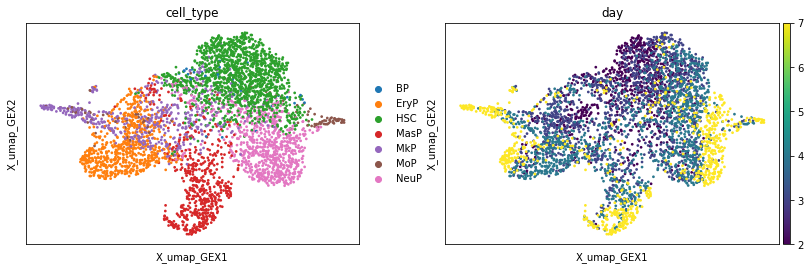

In [142]:
sc.pl.embedding(adata, basis="X_umap_GEX", color=["cell_type", "day"])

We can also plot a UMAP which was computed based on the ATAC data.

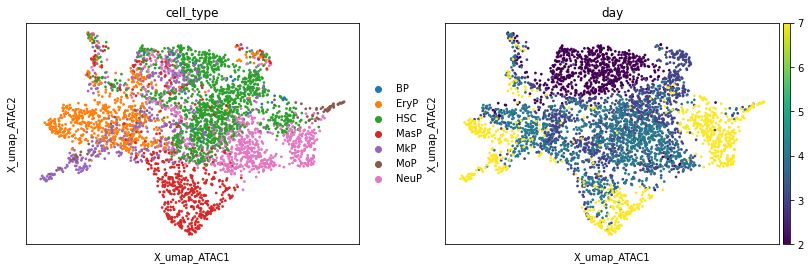

In [143]:
sc.pl.embedding(adata, basis="X_umap_ATAC", color=["cell_type", "day"])

## Creating a latent space incorporating information from both GEX and ATAC

As we want to leverage information from both modalities, we need to find a shared space of GEX and ATAC. There are different ways to obtain this, e.g., via [scvi-tools](https://scvi-tools.org/) models. Here, we simply concatenate the PCA-reduced GEX space and the LSI-reduced ATAC space and run PCA on the joint space.

As we want both modalities to have a comparable influence on the transport map, we need to make sure that the total variances are comparable.

In [144]:
np.var(adata.obsm["X_lsi"]), np.var(adata.obsm["X_pca"])

(1.0000002, 39.049347)

Standardization to unit variance is part of LSI, hence we only adapt the PCA-embedding of the gene expression. 

In [145]:
adata.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata.obsm["X_pca"])
adata.obsm["X_shared"] = sc.pp.pca(
    np.concatenate((adata.obsm["X_pca_scaled"], adata.obsm["X_lsi"]), axis=1),
    n_comps=30,
)

## Prepare the {class}`~moscot.problems.time.TemporalProblem`

First, we instantiate the {class}`~moscot.problems.time.TemporalProblem`

In [146]:
tp = TemporalProblem(adata)

We can adapt the marginals of the OT problem. By default, marginals are chosen to be uniform. This means that, even if each cell in the early time point has multiple possible descendants in the later time point, the proportions of the descendants sum up to "the mass of one cell". In developing systems we know that some cells might proliferate more than others. We can account for this by adapting the marginals based on proliferation and apoptosis markers with {meth}~`moscot.problems.time.TemporalProblem.score_genes_for_marginals`. 

:::{seealso}
- See {doc}`../examples/problems/500_passing_marginals` on how to pass custom marginals. 
:::

In [147]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

Now we can investigate the proliferation and apoptosis markers on the UMAP. Proliferation markers are much stronger than apoptosis markers, which can be seen from the range of the scores. This is to be expected, as we are in a developmental setting.

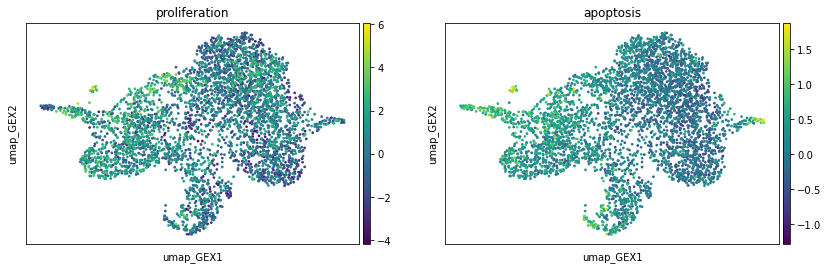

In [148]:
sc.pl.embedding(adata, basis="umap_GEX", color=["proliferation", "apoptosis"])

We use the above scores to adapt the left marginals of our OT problems. By default, this is done via a birth death process ({cite}`schiebinger:19`), but we can also do this using a more tunable and interpretable way.

:::{seealso}
- See {doc}`../examples/problems/800_score_genes_for_marginals` on examples how to use {meth}~`moscot.problems.time.TemporalProblem.score_genes_for_marginals`. 
:::


Now we can prepare the problem. Therefore we need to pass some information:

- `time_key`: defines the {attr}`obs <anndata.AnnData.obs>` column for the temporal information.
- `joint_attr`: defines based on which (latent) space we compute the distances for the OT problem. In this case, we use the latent space constructed above. 

:::{seealso}
- See {doc}`../examples/problems/200_custom_cost_matrices` on how to pass precomputed cost matrices. 
- See {doc}`../examples/problems/400_subset_policy` on how to choose pairs of time points between which to compute OT maps. 
:::

In [149]:
tp = tp.prepare(time_key="day", joint_attr="X_shared")

Now we can investigate the prior growth rate estimates.

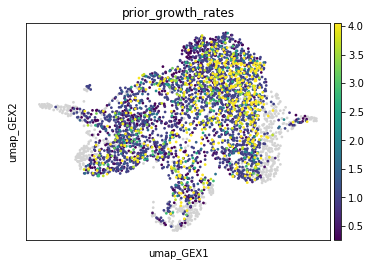

In [150]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates

sc.pl.embedding(adata, basis="umap_GEX", color="prior_growth_rates")

## Solve the {class}~`moscot.problems.time.TemporalProblem`


Now we can solve the problem. We set `epsilon` to be relatively small to get a sparse mapping between cells. Although we have a prior estimate of proliferation score of the cells, we still allow for adjustments of these prior estimates by setting `tau_a=0.99`. `tau_b=0.999` as we don't expect many cells to die in this developmental setting. Nevertheless, we don't want to be in the fully balanced case to reduce the influence of possible outliers. `scale_cost` is set to `mean`, which simply means that we normalize the entries of the cost matrix by its mean to stabilize training.

In [151]:
tp = tp.solve(epsilon=1e-3, tau_a=0.99, tau_b=0.999, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


## Interpreting the solution

### Growth rates

We can compare the posterior growth rates with the prior growth rates to see the influence of the unbalancedness parameters `tau_a` and `tau_b`. Note that setting `tau_a = tau_b = 1` would result in posterior growth rates being equal to prior growth rates.

In [152]:
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

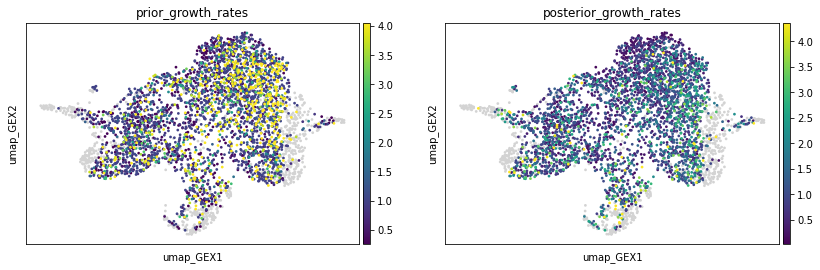

In [153]:
sc.pl.embedding(
    adata,
    basis="umap_GEX",
    color=["prior_growth_rates", "posterior_growth_rates"],
    vmax="p99",
)

To learn more about the influence of each single cell to the resulting coupling, we plot the `"cell costs"` in the source, and target distribution, respectively. High values indicate that a certain cell is unlikely to have a descendant or ancestor, respectively. One should consider removing them and rerunning the algorithm.

In [154]:
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

We can see that there are a few cells which influence the coupling more strongly than others, but the extend is still moderate, so we continue without removing them. 

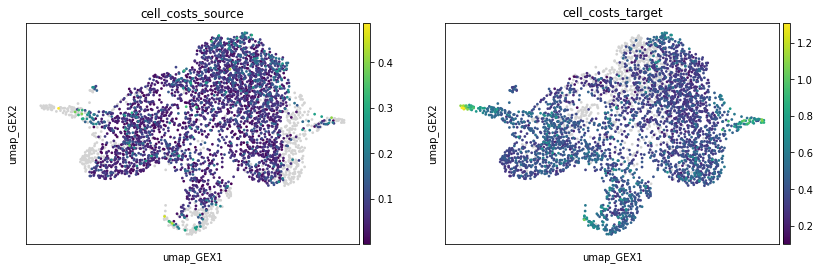

In [155]:
sc.pl.embedding(
    adata, basis="umap_GEX", color=["cell_costs_source", "cell_costs_target"]
)

## Identifying ancestry of cells.

We can now investigate which ancestry population a certain cell type has. We do this by aggregating the transport matrix by cell type, using {meth}~`moscot.problems.time.TemporalProblem.cell_transition`

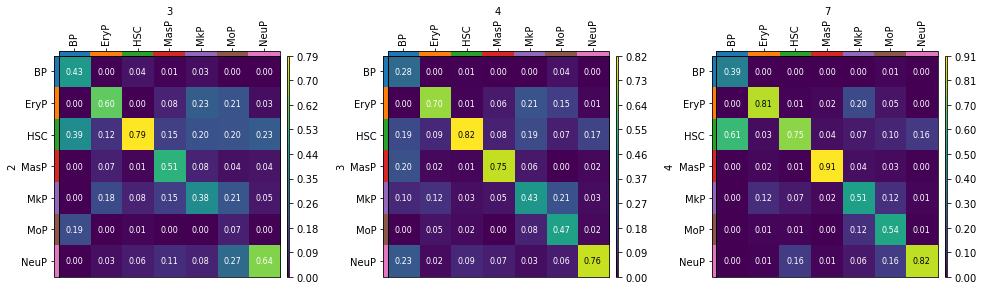

In [156]:
ct_desc = tp.cell_transition(
    2, 3, "cell_type", "cell_type", forward=False, key_added="transitions_2_3"
)
ct_desc = tp.cell_transition(
    3, 4, "cell_type", "cell_type", forward=False, key_added="transitions_3_4"
)
ct_desc = tp.cell_transition(
    4, 7, "cell_type", "cell_type", forward=False, key_added="transitions_4_7"
)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))

axes[0] = mpl.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[0],
    uns_key="transitions_2_3",
)

axes[1] = mpl.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[1],
    uns_key="transitions_3_4",
)

axes[2] = mpl.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    return_fig=True,
    ax=axes[2],
    uns_key="transitions_4_7",
)

fig.subplots_adjust(wspace=0.4)

The transition matrices shows the ancestry of each cell type. For example, looking at the left transition matrix, we see that BPs at time point `3` are mainly derived from HSCs or BPs (first column). Analogously, NeuPs at time point `3` are mainly derived from HSCs and NeuPs (last column).


## Visualizing ancestors and descendants

We can also visualize ancestors and descendants, e.g. on a UMAP, by using the {func}`~moscot.plotting.pull` and {func}`~moscot.plotting.push`, respectively. We start with descendants of all cells at time point `4`.

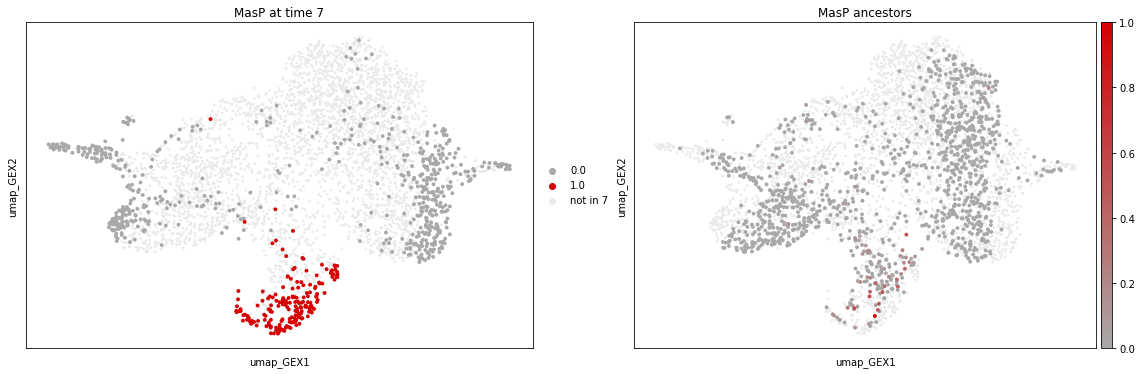

In [157]:
tp.pull(source=4, target=7, data="cell_type", subset="MasP")

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

axes[0] = mpl.pull(
    tp,
    time_points=[7],
    basis="umap_GEX",
    fig=fig,
    ax=axes[0],
    return_fig=True,
    title=["MasP at time 7"],
)
axes[1] = mpl.pull(
    tp,
    time_points=[4],
    basis="umap_GEX",
    fig=fig,
    ax=axes[1],
    return_fig=True,
    title=["MasP ancestors"],
)

fig.subplots_adjust(wspace=0.2)

The left plot above colorizes all MasP cells at time point `7` in red. All other cells in time point `7` are dark gray, while cells not measured at time point `7` are light gray. The left plot shows the ancestry likelihood of each cell on a palette from red (very likely ancestor) to dark gray (very unlikely ancestor). All cells not belonging to time point `4` are light gray.

We can also visualize the descendants of a certain subgroup. For example, we can visualize the descendants of HSCs at time point `2`.

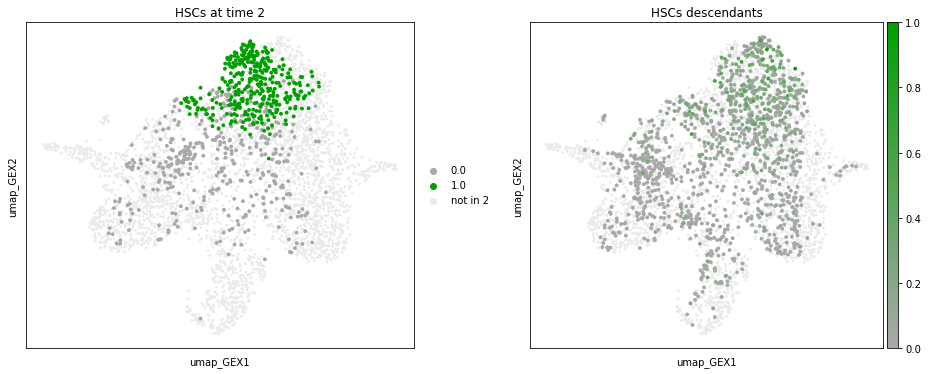

In [158]:
tp.push(source=2, target=3, data="cell_type", subset="HSC")
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

axes[0] = mpl.push(
    tp,
    time_points=[2],
    basis="umap_GEX",
    fig=fig,
    ax=axes[0],
    return_fig=True,
    title=["HSCs at time 2"],
)
axes[1] = mpl.push(
    tp,
    time_points=[3],
    basis="umap_GEX",
    fig=fig,
    ax=axes[1],
    return_fig=True,
    title=["HSCs descendants"],
)

fig.subplots_adjust(wspace=0.3)

To get an idea of the dynamics across all time points, we can visualize the cell type evolution with a {func}`~moscot.plotting.sankey` diagram. We choose `threshold=0.05`, which ignores all transitions with a probability of less than `0.05`. 

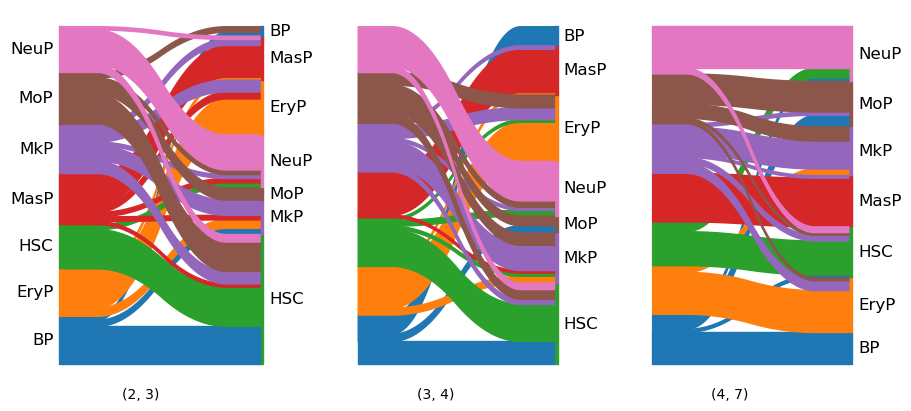

In [159]:
tp.sankey(
    source=2,
    target=7,
    source_groups="cell_type",
    target_groups="cell_type",
    threshold=0.05,
)
mpl.sankey(tp, dpi=100, figsize=(9, 4))

## Finding new subclusters 

So far we only considered the cell type annotations to perform trajectory inference.
The {class}`~moscot.problems.time.TemporalProblem` is helpful to detect trajectories of subpopulations. Therefore, we subcluster the HSC population.

As mentioned above, the cell type annotation is based on gene expression only, and hence does not take the ATAC modality into account, while our computed transport maps leverage both modalities.
For subclustering we will now also use both modalities. Thus, we compute the neighbors based on our joint embedding.

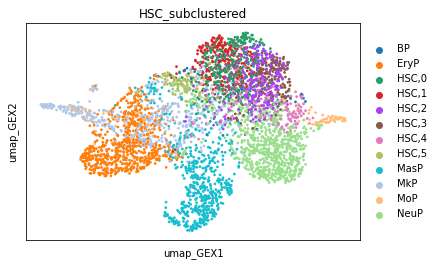

In [161]:
sc.pp.neighbors(adata, use_rep="X_shared")

new_key = "HSC_subclustered"
sc.tl.leiden(
    adata, restrict_to=("cell_type", ["HSC"]), key_added=new_key, resolution=0.5
)

sc.pl.embedding(adata, color=new_key, basis="umap_GEX")

Now, we can consider the transitions between the subclusters.
Therefore, we consider where the subclusters of HSCs at time point `3` are mapped to in time point `4`.

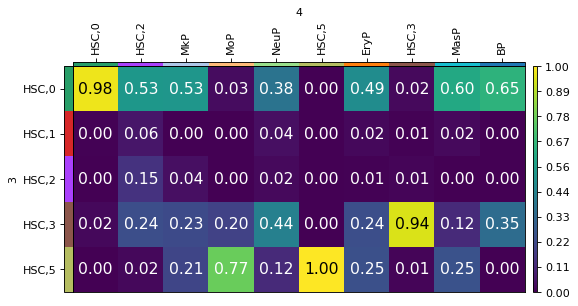

In [162]:
tp.cell_transition(
    3,
    4,
    source_groups={new_key: ["HSC,0", "HSC,1", "HSC,2", "HSC,3", "HSC,4", "HSC,5"]},
    target_groups=new_key,
    forward=False,
)
mpl.cell_transition(tp, dpi=80, fontsize=14)

We can see that MoP cells mainly evolve from the HSC,5 subcluster while BP cells have progenitors in both HSC,0 and HSC,3.